# Daten laden und vorverarbeiten

In [ ]:
import pandas as pd
import re
import spacy
import requests
from gensim import models
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#nltk.download('punkt')

from sklearn.model_selection import ParameterGrid
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim_models

import warnings, logging
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


In [1]:
def load_data(file_path):
    df = pd.read_csv(file_path, encoding='utf-8')
    return df

def preprocess_text(text):
    text = re.sub(r'[^\w\s]' , ' ', text)
    
    email = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
    text = email.sub('', text)
    
    url= re.compile(r'http?s//:\S+')
    text = url.sub('', text)
    
    text = re.sub(r"\d+", " ", text)
    text = re.sub("\'", "", text)
    text = re.sub('\n', ' ', text)
    text = text.strip()
    text = text.lower()
    return text

def tokenize_text(text):
    return word_tokenize(text, language='german')

def make_bigrams(texts):
    bigram = Phrases(texts, min_count=5, threshold=100)
    bigram_mod = Phraser(bigram)
    return [bigram_mod[text] for text in texts]

def make_trigrams(texts):
    bigram = Phrases(texts, min_count=7, threshold=100)
    bigram_mod = Phraser(bigram)
    trigram = Phrases(bigram[texts], threshold=100)
    trigram_mod = Phraser(trigram)
    return [trigram_mod[bigram_mod[text]] for text in texts]

def lemmatize(texts, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for text in texts:
        word_list = nlp(" ".join(text))
        texts_out.append([word.lemma_.lower() for word in word_list if word.pos_ in allowed_postags])
    return texts_out

def remove_stopwords(texts, stop_words):
    return [[word for word in text if word.lower() not in stop_words] for text in texts]

In [2]:
# Laden der Daten
url = "https://ordnungsamt.berlin.de/frontend.webservice.opendata/api/meldungen"
response = requests.get(url).json()
df = pd.json_normalize(response, record_path=['index'])
df.replace(to_replace=[None], value='', inplace=True)

# Bereinigung
df['sachverhalt_clean'] = df['sachverhalt'].map(preprocess_text)
data = df['sachverhalt_clean'].values.tolist()

# Tokenisierung
data_tokenized = [tokenize_text(word) for word in data]

# Laden der Stoppwörter
stop_words = stopwords.words('german')
custom_stopwords = ['komplett', 'seit', 'vier', 'tag', 'kz', 'hinein', 'darauf', 'sowie', 'einzeln', 'seit', 'woche', 'drumherum', 'hallo', 'mitteilen', 'gottlieb', 'moment', 'bluten', 'herz', 'fallen', 'kein_möglichkeit', 
                    'vielleicht', 'mit_freundlich_grüße', 'zeitweise', 'rund_um', 'regelmäßig', 'daneben', 'sodass', 'unschön', 'woche', 'diverse', 'zahlreich', 'extratische', 'tante', 'lisbeth', 'öffnen', 'tag', 
                    'herrenlose', 'gebet', 'bitte', 'helfen', 'heute_morgen', 'alt', 'eigentlich', 'dagegen', 'entlich_mal', 'leern', 'woche', 'destages', 'schön_wenn', 'meldung', 'wegen', 'lang', 'schwarz', 'vieler', 
                    'monat', 'insbesondere', 'seite', 'natürlich', 'erklärung', 'leid', 'kontinuierlich', 'wem', 'inzwischen', 'dadurch', 'bevor', 'u_bhf', 'ost', 'sin', 'genau', 'eher', 'ok', 'gesamt', 'gut_tag', 
                    'einiger_zeit', 'ab', 'nr', 'irgendwann', 'ange', 'bsr', 'zwei', 'weit', 'etwa', 'los', 'z_--', 'oft', 'ca_m', 'n', 'e', 'n', 'grad', 'h', 'quasi', 'aller_art', 'usw', 'ab', 'lt', 'bsr', '°', 'pa', 
                    'gut_tag', 'fraenkelufer', 'so_nah', 'wieso', 'ich_glauben', 'paar', 'wir_bitten', 'um_prüfung', 'herzlich_dank', 'ps', 'lassen', 'wissen', 'sollen', 'totaler', 'unmeng', 'gut_tag', 'wieder_einmal', 
                    'nähe', 'kieferorthopädie', 'mittlerweile', 'fast', 'gute_grüße', 'hinaus', 'leider', 'nah', 'meist', 'gerne', 'soo', 'zb', 'oä', 'vor_ort', 'klar', 'je', 'wann', 'irgendwann', 'genug', 'meh', 'kvz', 
                    'danke', 'vüd', 'ord', '￼', 'modellvielfältigkeit', 'mehrere', 'ihr_fahrräder_aller_art', 'ausgangspunkt', 'herr_anbei', 'v_nachgang_mein_mitteilung', 'lt_img_jpeg_gt', 'lt_jpeg_gt_lt', 'um_schreiben_k', 
                    'jpeg_gt', 'groß', 'fahrzeug_werden_nicht_ordnungsgemäß_parken_weder', 'div', 'de', 'y', 'z', 'kx', 'vl', 'bisher', 'deutlich', 'weit', 'rund_um', 'sich_hierbei', 'ich_glauben',  'teil', 'i', 'te', 
                    'cm', 'a', 'aod', 'lg', 'gesntworten', 'viele_dank', 'sehen', 'bild', 'sehen_bild', 'kubikmeter', 'ihr_freundlich', 'uhr_topf_aufeinander_knallen', '--_foto', 'art_modellvielfältigkeit', 'leut', 
                    'o', 'sehr_geehrt', 'vieler_dank', '--', 'wer', 'generell', 'ebenfalls', 'gar', 'team', 'bahcesi', 'merhaba', 'frühsn', 'seir', 'x', 'dba', 'mfg', 'bzw', 'sehr_geehrt_dame', 'u', 'teilweise', 'wdh', 
                    'ca_m³', 'xxd', 'gut', 'sehen_foto', 'herum', 'manfred_von', 'grüße_r', 'Scherzh', 'k', 'd', 'g', 'str', 'm', 'x', 'oa', 'vg', 'f', 's', 'qm', 'ca', 'siehe_Foto', 'bild', 'art', 'siehe_bild', 'direkt', 
                    'foto', 'ganz', 'diverser', 'Paragraphenzeichen', 'Summenfolg', 'Eiskast', 'Pott', 'zuzuordn', 'Modellvielfältigkeit', 'K_V', 'gemäß', 'Scherzhaft', 'fig', 'scherzhaft', 'kommentierend', 'durch_Bodenwisch', 
                    'ihren_Fahrräder', 'Sehr_geehrte_Damen', 'Mit_freundlich', 'Grüßen_K_', 'Meldungsnummer_qq', 'PB', 'ja', 'Hauptform', 'durch_bodenwisch', 'her', 'nsch', 'sehr_geehrte_damen', 'übersende_ich', 'ihren_fahrräder', 
                    'paragraphenzeiche', 'ihre_freundlich', 'mehr', 'k_v', 'scherzh', 'gt_lt', 'mehr_benutzung', 'leutselig_grüß', 'pb', 'so_dassen', 'bild', 'gab_es', 'siehe_bild', 'foto', 'ggü', 'etc', 'zmr', 'meldungsnr', 
                    'lagetsi', 'ich_möchn', 'tun', 'hab_ich', 'gerade', 'dennoch', 'gleich', 'immer', 'bereits', 'rum', 'völlig', 'weidl', 'stefanie', 'pöthig', 'hierüber', 'geehrt', 'damen', 'und', 'herren', 'schon', 
                    'herr', 'häufig', 'dame', 'ich_möchten', 'immerhin', 'grüßenk', 'geehrte_damen', 'vsehr', 'mal', 'seeehr', 'grüßenstefanie', 'lieb', 'berlintel', 'mit_freundlich', 'auf_dem', 'u_a', 
                    'hiermit', 'soweit', 'zudem', 'siehe_foto', 'nicht_mehr', 'mehr_als', 'freundlich_grüße', 'sehr_geehrt_dame_und_herr', 'anbei_übersenden', 'gt_schreiben', 'gt', 'schreiben', 'nachgang_mitteilung', 
                    'genehmigungsfähig_sondernutzung', 'pfo', 'meldungsnummer', 'bemühung', 'v', 'nachgang', '§', 'freundlich', 'mitteilung', 'übersend', 'grüßen', 'phänom', 'sache', 'sonstig','speisere', 
                    'blau', 'gelb', 'säck', 'passier', 'anzeig', 'tret', 'höhe', 'ecke', 'funktion',  'geehrte', 'jahr', 'essensre', 'situation', 'säcken', 'rechter', 'zeit', 'teilbereich', 'bügel', 'unbekannt', 'besitzer', 
                    'sine', 'weiß', 'firma', 'antwort', 'scher', 'kollege', 'matratz', 'ort', 'stelle', 'richtung', 'dritter', 'östlich', 'teller', 'letzter', 'verschieden', 'mülltonn', 'maßnahme', 'fahrzeug_feuerwehr_müllabfuhr',
                    'klein', 'menge', 'meter', 'bereich', 'hausnummer', 'verständnis', 'derzeitig', 'aktuell', 'müsste', 'fotos', 'fall', 'herse', 'gucken', 'kettinger', 'föttinger', 'ketting', 'ostseite', 'minute', 'video',
                    'entsprechend', 'erkenn', 'rot', 'verbreit', 'ä', 'allfällig', 'geben', 'entlich', 'unverändert', 'freundlichen', 'scheinen', 'ki', 'nutzen', 'kommen', 'knallen_uhr', 'uhr_geräusch', 'töpfe_knallen', 
                    'uhr_geräusch_bodenwisch_uhr', 'wand', 'uhr_maschine', 'uhr_töpfe', 'dortig']

stop_words.extend(custom_stopwords)
stop_words = [word.lower() for word in stop_words]

# Entfernen von Stoppwörtern
data_without_stopwords = remove_stopwords(data_tokenized, stop_words)

# Lemmatisierung und Entfernen von Stoppwörtern
#!python -m spacy download de_core_news_sm
nlp = spacy.load("de_core_news_sm")
data_lemmatized = lemmatize(data_without_stopwords, nlp, allowed_postags=['NOUN', 'ADJ'])

# Entfernen von Stoppwörtern
data_without_stopwords = remove_stopwords(data_lemmatized, stop_words)


# Anwenden von Bigrammen
# words_bigram = make_bigrams(words_tokenized)
# Anwenden von Trigrammen
data_trigram = make_trigrams(data_without_stopwords)

# Entfernen von Stoppwörtern
data_without_stopwords = remove_stopwords(data_trigram, stop_words)

# entferne leere Listenelemente
data_ready = [words for words in data_without_stopwords if words]

# Aufbau des Wörterbuchs und des Bag-of-Words-Korpus
id2word = Dictionary(data_ready)
print(f"Vokabular vor der Filterung: {len(id2word)}")
id2word.filter_extremes(no_below=10, no_above=0.6, keep_n=1000) 
print(f"Vokabular nach der Filterung: {len(id2word)}")

bow_corpus = [id2word.doc2bow(text, allow_update=True) for text in data_ready]

Vokabular vor der Filterung: 3666
Vokabular nach der Filterung: 149


# Finden des besten Models mithilfe von Grid Search

In [4]:
def grid_search_lda(corpus, dictionary, texts, num_topics):
    # Parameter-Grid für die Grid-Suche
    param_grid = {
        'num_topics': num_topics,
        'decay': [0.5, 0.7, 1.0],
        'chunksize': [50],
        'passes': [10, 20, 30, 50], #, 50
        'alpha': [0.0001, 0.0003, 0.0005, 0.0007, 0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1],
        'eta': [0.0001, 0.0003, 0.0005, 0.0007, 0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1],
    }

    best_model = None
    best_coherence = -np.inf
    best_perplexity = np.inf

    # Durchlaufe alle Kombinationen der Parameter im Parameter-Grid
    for params in ParameterGrid(param_grid):
        # Erstelle das Modell
        model = models.LdaModel(corpus=corpus, id2word=dictionary, **params)

        # Berechne die Kohärenz für das aktuelle Modell
        coherence_model = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_score = coherence_model.get_coherence()
        
        # Berechne die Perplexität
        perplexity = model.log_perplexity(model[corpus])
        
        # Ausgabe der Modellparameter
        print(f"Model Parameters: {params}")

        # Aktualisiere das beste Modell, falls das aktuelle Modell eine bessere Kohärenz aufweist
        if (abs(coherence_score) < abs(best_coherence)):
            best_model = model
            best_coherence = coherence_score
            best_perplexity = perplexity

    return best_model, best_coherence, best_perplexity

def grid_search_lda_tfidf(corpus, dictionary, texts, num_topics):
    # Parameter-Grid für die Grid-Suche von TF-IDF und LDA
    param_grid = {
        'num_topics': num_topics,
        'decay': [0.5, 0.7, 1.0],
        'chunksize': [50],
        'passes': [10, 20, 30, 50],
        'alpha': [0.0001, 0.0003, 0.0005, 0.0007, 0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1],
        'eta': [0.0001, 0.0003, 0.0005, 0.0007, 0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1], 
    }

    smartirs_options = ['nfc', 'ntc'] 
    
    best_model = None
    best_corpus = None
    best_coherence = -np.inf
    best_perplexity = np.inf
    
    # Durchlaufe alle Kombinationen der Parameter im kombinierten Parameter-Grid
    for smartirs in smartirs_options:
        # Erstelle das TF-IDF-Modell
        tfidf_model = models.TfidfModel(corpus, dictionary=dictionary, smartirs=smartirs)
        tfidf_corpus = tfidf_model[corpus]
        
        print(f'TF-IDF Smartirs: {smartirs}')
        for params in ParameterGrid(param_grid):
            # Erstelle das LDA-Modell
            model = models.LdaModel(corpus=tfidf_corpus, id2word=dictionary, **params)

            # Berechne die Kohärenz für das aktuelle LDA-TF-IDF-Modell
            coherence_model = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
            coherence_score = coherence_model.get_coherence()

            # Berechne die Perplexität
            perplexity = model.log_perplexity(model[tfidf_corpus])

            # Ausgabe der Modellparameter
            print(f"Model Parameters: {params}")

            # Aktualisiere das beste Modell, falls das aktuelle Modell eine bessere Kohärenz aufweist
            if (abs(coherence_score) < abs(best_coherence)):
                best_model = model
                best_corpus = tfidf_corpus
                best_coherence = coherence_score
                best_perplexity = perplexity

    return best_model, best_corpus, best_coherence, best_perplexity

def grid_search_lsa(corpus, dictionary, texts, num_topics):
    # Parameter-Grid für die Grid-Suche
    param_grid = {
        'num_topics': num_topics,
        'decay': [0.5, 0.7, 1.0],
        'chunksize': [50],
        'power_iters': [1, 5, 10, 20, 30, 50],  
    }

    best_model = None
    best_coherence = -np.inf
    best_perplexity = np.inf

    # Durchlaufe alle Kombinationen der Parameter im Parameter-Grid
    for params in ParameterGrid(param_grid):
        # Erstelle das Modell
        model = models.LsiModel(corpus=corpus, id2word=dictionary, **params)

        # Berechne die Kohärenz für das aktuelle Modell
        coherence_model = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_score = coherence_model.get_coherence()
        
        # Berechne die Perplexität
        perplexity = calculate_lsa_perplexity(model=model, corpus=corpus)
        
        # Ausgabe der Modellparameter
        print(f"Model Parameters: {params}") 

        # Aktualisiere das beste Modell, falls das aktuelle Modell eine bessere Kohärenz aufweist
        if (abs(coherence_score) <= abs(best_coherence)) and (perplexity < best_perplexity):
            best_model = model
            best_coherence = coherence_score
            best_perplexity = perplexity

    return best_model, best_coherence, best_perplexity

def grid_search_lsa_tfidf(corpus, dictionary, texts, num_topics):
    # Parameter-Grid für die Grid-Suche von TF-IDF und LDA
    param_grid = {
        'num_topics': num_topics,
        'decay': [0.5, 0.7, 1.0],
        'chunksize': [50],
        'power_iters': [1, 5, 10, 20, 30, 50],  
    }

    smartirs_options = ['lpn', 'txn', 'tpn'] 
    
    best_model = None
    best_corpus = None
    best_coherence = -np.inf
    best_perplexity = np.inf
    
        # Durchlaufe alle Kombinationen der Parameter im kombinierten Parameter-Grid
    for smartirs in smartirs_options:
        # Erstelle das TF-IDF-Modell
        tfidf_model = models.TfidfModel(corpus, dictionary=dictionary, smartirs=smartirs)
        tfidf_corpus = tfidf_model[corpus]
        
        print(f'TF-IDF Smartirs: {smartirs}')
        for params in ParameterGrid(param_grid):
            # Erstelle das LSA-Modell
            model = models.LsiModel(corpus=tfidf_corpus, id2word=dictionary, **params)

            # Berechne die Kohärenz für das aktuelle LDA-TF-IDF-Modell
            coherence_model = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
            coherence_score = coherence_model.get_coherence()

            # Berechne die Perplexität
            perplexity = calculate_lsa_perplexity(model=model, corpus=tfidf_corpus)

            # Ausgabe der Modellparameter
            print(f"Model Parameters: {params}") 

            # Aktualisiere das beste Modell, falls das aktuelle Modell eine bessere Kohärenz aufweist
            if (abs(coherence_score) < abs(best_coherence)) and (perplexity <= best_perplexity):
                best_model = model
                best_corpus = tfidf_corpus
                best_coherence = coherence_score
                best_perplexity = perplexity
    
    return best_model, best_corpus, best_coherence, best_perplexity
   
# Formel für die Berechnung der Perpläxität für LdaModel
# Perplexität = exp(-1. * Log-Likelihood pro Wort)
def calculate_lsa_perplexity(model, corpus):
    count = len(corpus)
    log_likelihood = 0.0
    nonzero_count = 0
    
    # Holt die Themen und ihre Wahrscheinlichkeiten für das aktuelle Dokument aus dem Modell
    for doc in corpus:
        topics = model[doc] 
        for topic, prob in topics:
            if prob > 0:
                # Füge eine kleine Konstante (1e-10) hinzu, um Probleme beim Berechnen des Logarithmus sehr kleiner Wahrscheinlichkeiten zu vermeiden
                log_likelihood += np.log(prob + 1e-10)
                nonzero_count += 1

    if nonzero_count > 0:
        # Berechne die Perplexität basierend auf der Formel: 
        # Perplexity = exp(-log_likelihood / nonzero_count)
        perplexity = np.exp(-log_likelihood / nonzero_count)
    else:
        # Wenn es keine nicht-negativen Wahrscheinlichkeiten gibt, wird die Perplexität auf Unendlich gesetzt
        perplexity = np.inf  

    return perplexity

In [5]:
no_topics =range(2, 6, 1)

In [6]:
# Initialize lists to store coherence scores for each method
coherence = []
perplexity = []

best_coherence_lda_bow = -np.inf
best_coherence_lda_tfidf = -np.inf
best_coherence_lsa_bow = -np.inf
best_coherence_lsa_tfidf = -np.inf


for n in no_topics:
    # LDA BoW
    lda_bow_model, lda_bow_coherence, lda_bow_perplexity = grid_search_lda(corpus=bow_corpus, dictionary=id2word, texts=data_ready, num_topics=[n])
    
    coherence.append(lda_bow_coherence)
    perplexity.append(lda_bow_perplexity)
    
    if abs(lda_bow_coherence) < abs(best_coherence_lda_bow):
        best_coherence_lda_bow = lda_bow_coherence
        perplexity_lda_bow = lda_bow_perplexity
        best_model_lda_bow = lda_bow_model
    
    
    # LSA BoW
    lsa_bow_model, lsa_bow_coherence, lsa_bow_perplexity = grid_search_lsa(corpus=bow_corpus, dictionary=id2word, texts=data_ready, num_topics=[n])
    
    coherence.append(lsa_bow_coherence)
    perplexity.append(lsa_bow_perplexity)
    
    if abs(lsa_bow_coherence) < abs(best_coherence_lsa_bow):
        best_coherence_lsa_bow = lsa_bow_coherence
        perplexity_lsa_bow = lsa_bow_perplexity
        best_model_lsa_bow = lsa_bow_model

    
    # LDA TF-IDF
    lda_tfidf_model, lda_tfidf_corpus, lda_tfidf_coherence, lda_tfidf_perplexity = grid_search_lda_tfidf(corpus=bow_corpus, dictionary=id2word, texts=data_ready, num_topics=[n])
    
    coherence.append(lda_tfidf_coherence)
    perplexity.append(lda_tfidf_perplexity)
    
    if abs(lda_tfidf_coherence) < abs(best_coherence_lda_tfidf):
        best_coherence_lda_tfidf = lda_tfidf_coherence
        perplexity_lda_tfidf = lda_tfidf_perplexity
        best_model_lda_tfidf = lda_tfidf_model
        corpus_lda_tfidf = lda_tfidf_corpus
    
    
    # LSA TF-IDF
    lsa_tfidf_model, lsa_tfidf_corpus, lsa_tfidf_coherence, lsa_tfidf_perplexity = grid_search_lsa_tfidf(corpus=bow_corpus, dictionary=id2word, texts=data_ready, num_topics=[n])

    coherence.append(lsa_tfidf_coherence)
    perplexity.append(lsa_tfidf_perplexity)

    if abs(lsa_tfidf_coherence) < abs(best_coherence_lsa_tfidf):
        best_coherence_lsa_tfidf = lsa_tfidf_coherence
        perplexity_lsa_tfidf = lsa_tfidf_perplexity
        best_model_lsa_tfidf = lsa_tfidf_model
        corpus_lsa_tfidf = lsa_tfidf_corpus

C:\Users\laura\anaconda3\envs\project_gpu\lib\site-packages\gensim\models\ldamodel.py:850: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


Model Parameters: {'alpha': 0.0001, 'chunksize': 50, 'decay': 0.5, 'eta': 0.0001, 'num_topics': 2, 'passes': 10}
Model Parameters: {'alpha': 0.0001, 'chunksize': 50, 'decay': 0.5, 'eta': 0.0001, 'num_topics': 2, 'passes': 20}
Model Parameters: {'alpha': 0.0001, 'chunksize': 50, 'decay': 0.5, 'eta': 0.0001, 'num_topics': 2, 'passes': 30}
Model Parameters: {'alpha': 0.0001, 'chunksize': 50, 'decay': 0.5, 'eta': 0.0003, 'num_topics': 2, 'passes': 10}
Model Parameters: {'alpha': 0.0001, 'chunksize': 50, 'decay': 0.5, 'eta': 0.0003, 'num_topics': 2, 'passes': 20}
Model Parameters: {'alpha': 0.0001, 'chunksize': 50, 'decay': 0.5, 'eta': 0.0003, 'num_topics': 2, 'passes': 30}
Model Parameters: {'alpha': 0.0001, 'chunksize': 50, 'decay': 0.5, 'eta': 0.0005, 'num_topics': 2, 'passes': 10}
Model Parameters: {'alpha': 0.0001, 'chunksize': 50, 'decay': 0.5, 'eta': 0.0005, 'num_topics': 2, 'passes': 20}
Model Parameters: {'alpha': 0.0001, 'chunksize': 50, 'decay': 0.5, 'eta': 0.0005, 'num_topics': 

# Visualisieren von Kohärenz und Perplexität

In [221]:
def plot_perplexity(perplexity_values, no_topics):
    # Erstelle eine Figur und Achse für das Diagramm
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Extrahiere die Perplexitätswerte für jede Methode
    perplexity_lda_bow = perplexity_values[0::4]
    perplexity_lsa_bow = perplexity_values[1::4]
    perplexity_lda_tfidf = perplexity_values[2::4]
    perplexity_lsa_tfidf = perplexity_values[3::4]

    # Plotten der Perplexitätswerte für jede Methode
    '''ax1.plot(no_topics, perplexity_lda_bow, label="LDA BoW")
    ax1.plot(no_topics, perplexity_lda_tfidf, label="LDA TF-IDF")
    ax1.plot(no_topics, perplexity_lsa_bow, label="LSA BoW")
    ax1.plot(no_topics, perplexity_lsa_tfidf, label="LSA TF-IDF")'''
    
    ax1.plot(no_topics, perplexity_lda_bow, label="LDA BoW", color='lightgray', linestyle='-', marker='o')
    ax1.plot(no_topics, perplexity_lda_tfidf, label="LDA TF-IDF", color='gray', linestyle='-', marker='o')
    ax1.plot(no_topics, perplexity_lsa_bow, label="LSA BoW", color='darkgray', linestyle='-', marker='o')
    ax1.plot(no_topics, perplexity_lsa_tfidf, label="LSA TF-IDF", color='black', linestyle='-', marker='o')


    # Beschriftungen und Titel setzen
    ax1.set_xlabel('Anzahl der Themen')
    ax1.set_ylabel("Perplexität")
    ax1.legend(loc='best')
    ax1.set_title('Perplexität in Abhängigkeit von der Anzahl der Themen')

    # Daten für die Tabelle unterhalb des Diagramms
    data = [perplexity_lda_bow, perplexity_lda_tfidf, perplexity_lsa_bow, perplexity_lsa_tfidf]
    data = [['%.2f' % j for j in i] for i in data]
    rows = ["LDA BoW", "LDA TF-IDF", "LSA BoW", "LSA TF-IDF"]
    columns = ['%d' % x for x in no_topics]

    # Tabelle unterhalb des Diagramms hinzufügen
    ax2 = plt.gca().twiny()
    ax2.axis("off")
    table = ax2.table(cellText=data, rowLabels=rows, colLabels=columns, rowLoc='center', loc='center', bbox=[0, -0.3, 1.0, 0.2]) #[xmin, ymin, width, height]
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Setze die Größe von ax2 auf die Größe von ax1
    ax2.set_position(ax1.get_position())

    # Speichere das Diagramm als Bild
    plt.savefig('perplexity.png', bbox_inches='tight', dpi=150)
    
    # Zeige das Diagramm an
    plt.show()

def plot_coherence(coherence_values, no_topics):
    # Erstelle eine Figur und Achse für das Diagramm
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Extrahiere die Kohärenzwerte für jede Methode
    coherence_lda_bow = coherence_values[0::4]
    coherence_lsa_bow = coherence_values[1::4]
    coherence_lda_tfidf = coherence_values[2::4]
    coherence_lsa_tfidf = coherence_values[3::4]
    
    # Plotten der Kohärenzwerte für jede Methode
    ax1.plot(no_topics, coherence_lda_bow, label="LDA BoW", color='lightgray', linestyle='-', marker='o')
    ax1.plot(no_topics, coherence_lda_tfidf, label="LDA TF-IDF", color='gray', linestyle='-', marker='o')
    ax1.plot(no_topics, coherence_lsa_bow, label="LSA BoW", color='darkgray', linestyle='-', marker='o')
    ax1.plot(no_topics, coherence_lsa_tfidf, label="LSA TF-IDF", color='black', linestyle='-', marker='o')
    
    # Beschriftungen und Titel setzen
    ax1.set_xlabel('Anzahl der Themen')
    ax1.set_ylabel("Kohärenz")
    ax1.legend(loc='best')
    ax1.set_title('Kohärenz in Abhängigkeit von der Anzahl der Themen')

    # Daten für die Tabelle unterhalb des Diagramms
    data = [coherence_lda_bow, coherence_lda_tfidf, coherence_lsa_bow, coherence_lsa_tfidf]
    data = [['%.2f' % j for j in i] for i in data]  # Runde die Werte auf zwei Dezimalstellen
    rows = ["LDA BoW", "LDA TF-IDF", "LSA BoW", "LSA TF-IDF"]
    columns = ['%d' % x for x in no_topics]
    
    # Tabelle unterhalb des Diagramms hinzufügen
    ax2 = plt.gca().twiny()
    ax2.axis("off")
    table = ax2.table(cellText=data, rowLabels=rows, colLabels=columns, rowLoc='center', loc='center', bbox=[0, -0.3, 1.0, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Setze die Größe von ax2 auf die Größe von ax1
    ax2.set_position(ax1.get_position())
    
    # Speichere das Diagramm als Bild
    plt.savefig('coherence_score.png', bbox_inches='tight', dpi=150)
    
    # Zeige das Diagramm an
    plt.show()

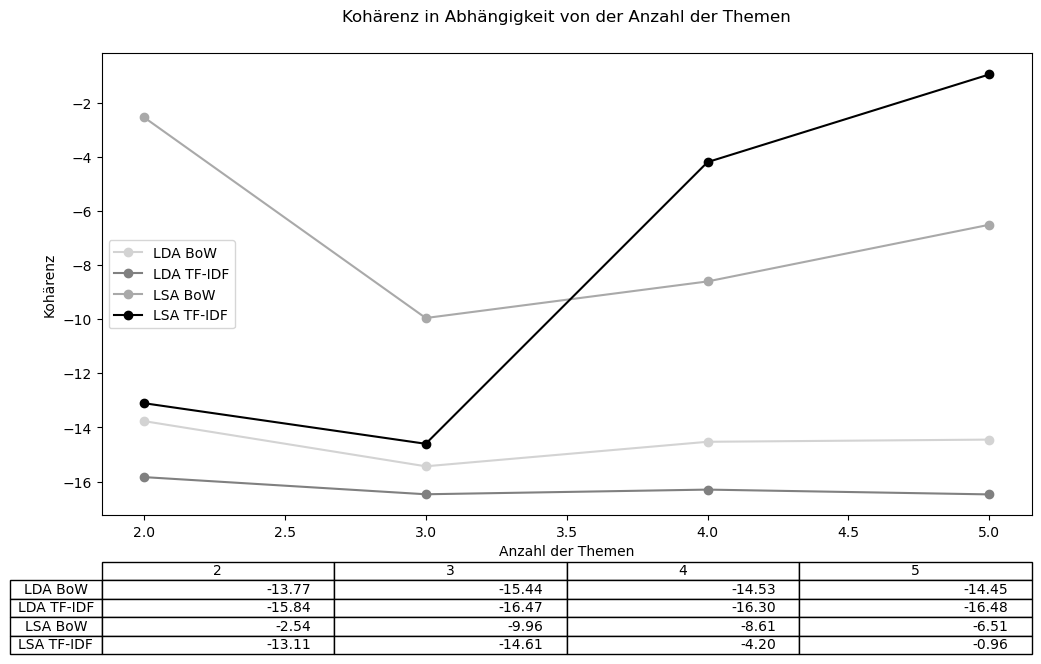

In [222]:
plot_coherence(coherence_values=coherence, no_topics=no_topics)

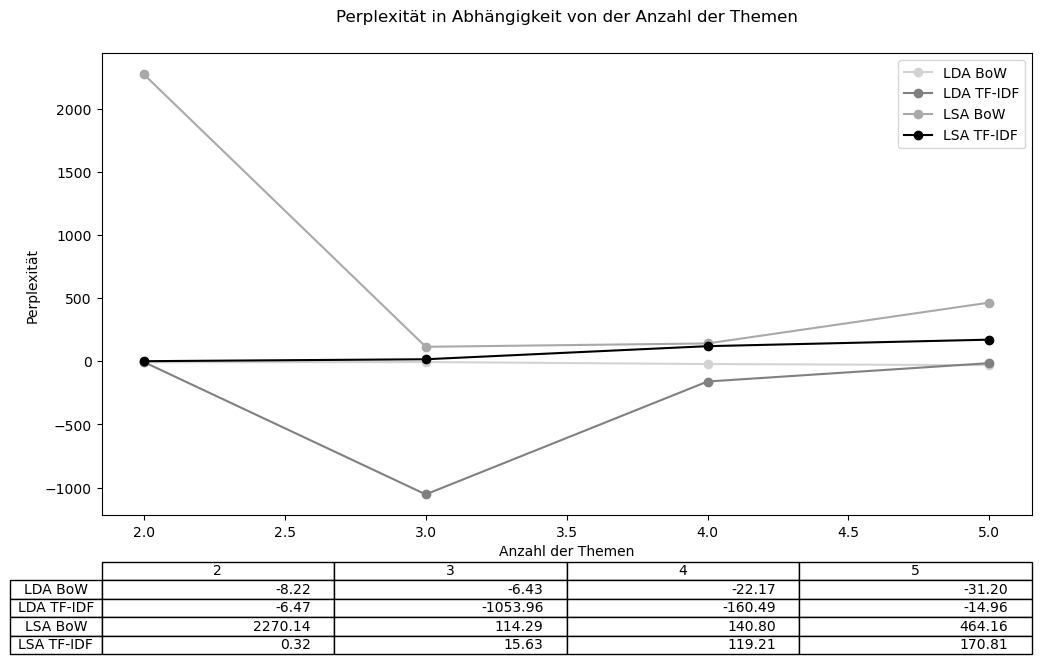

In [223]:
plot_perplexity(perplexity_values=perplexity, no_topics=no_topics)

# Visualisiere die Modelle

In [198]:
def coherence_per_topic(model, texts, dictionary, name):
    # Berechne die Kohärenz pro Thema
    coherence_model = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
    coherence_per_topic = coherence_model.get_coherence_per_topic()
    
    # Extrahiere die Wörter für jedes Thema und füge sie untereinander hinzu (hier nur 5 Terme)
    topics_str = ['\n'.join([term for term, _ in model.show_topic(topic, topn=5)]) for topic in range(model.num_topics)]
    
    # Erstelle ein DataFrame
    topic_score = pd.DataFrame(data=zip(topics_str, coherence_per_topic), columns=['Themen', 'Kohärenz'])
    topic_score = topic_score.set_index('Themen')

    # Plot
    fig, ax = plt.subplots(figsize=(4, 6))
    
    ax.set_title(f"Themenkohärenz für {str(model)}\n")
    
    sns.heatmap(data=topic_score, annot=True, square=False,
            cmap='gray', fmt='.2f', linewidths=1,
            linecolor='black', vmin=0, vmax=-18, ax=ax)
    
    plt.yticks(rotation=0)
    
    plt.savefig(f'Themenkohaerenz_{name}.png', bbox_inches='tight', dpi=150)
    
    plt.show()

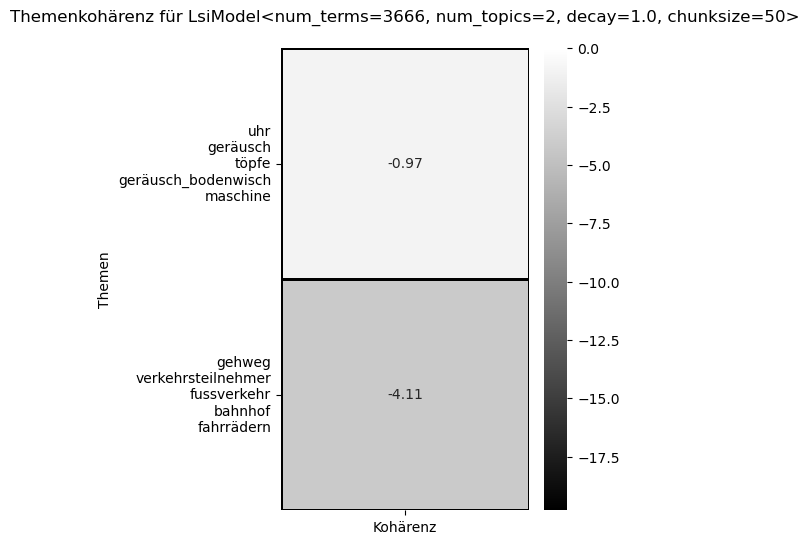

In [199]:
coherence_per_topic(model=best_model_lsa_bow, texts=data_ready, dictionary=id2word, name='LSA_BoW')

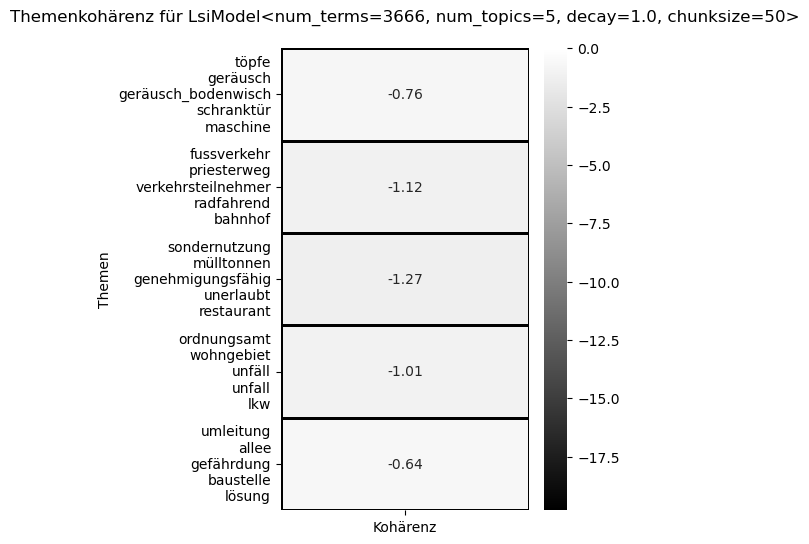

In [200]:
coherence_per_topic(model=best_model_lsa_tfidf, texts=data_ready, dictionary=id2word, name='LSA_TFIDF')

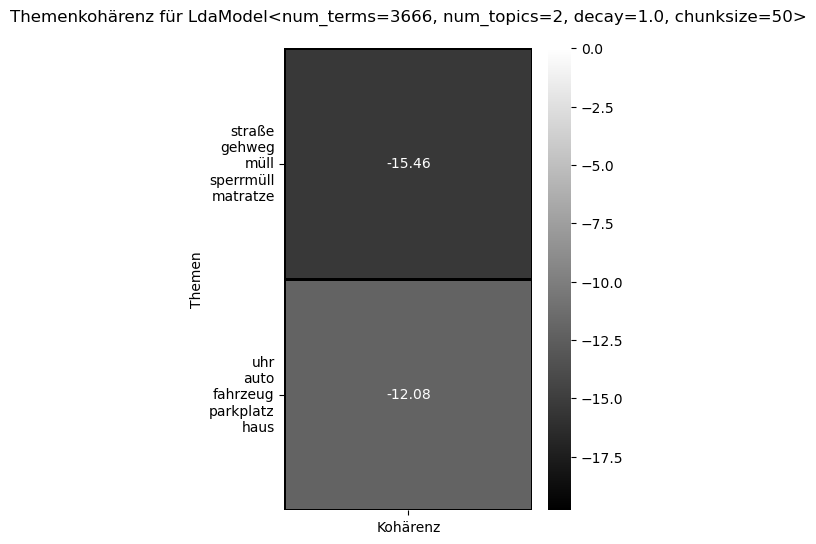

In [201]:
coherence_per_topic(model=best_model_lda_bow, texts=data_ready, dictionary=id2word, name='LDA_BoW')

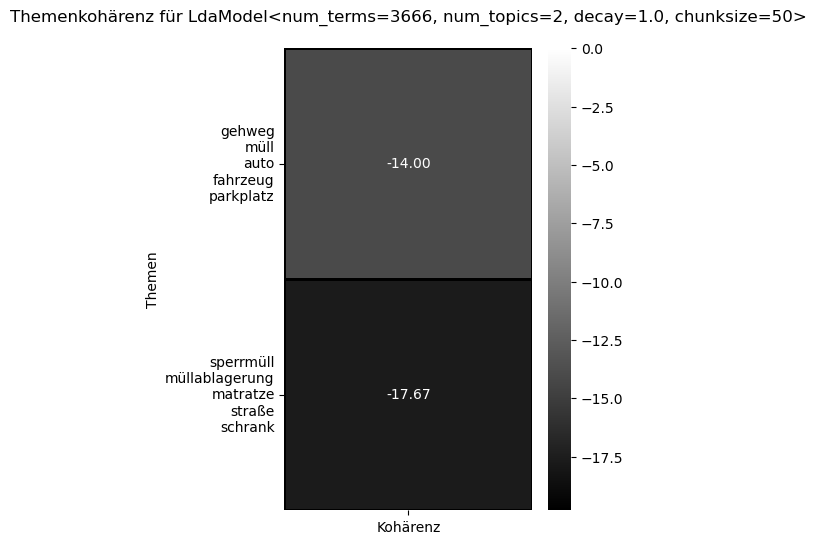

In [202]:
coherence_per_topic(model=best_model_lda_tfidf, texts=data_ready, dictionary=id2word, name='LDA_TFIDF')

In [279]:
from matplotlib.ticker import FuncFormatter
from gensim.corpora import Dictionary

def plot_topic_distribution(model, corpus, name):
    dominant_topics = []
    topic_percentages = []
    
    # Entpacke Werte aus dem Ergebnis basierend auf dem Modelltyp
    if isinstance(model, models.LdaModel):
        # Iteriere durch jedes Dokument im Korpus
        for idx, row in enumerate(corpus):
            topic_weights = model[row]
            dominant_topic = sorted(topic_weights, key = lambda x: x[1], reverse=True)[0][0]
            dominant_topics.append((idx, dominant_topic))
            topic_percentages.append(topic_weights)

    elif isinstance(model, models.LsiModel):
        # Iteriere durch jedes Dokument im Korpus
        for idx, row in enumerate(corpus):
            # Rufe die Ergebnisse des Modells für das aktuelle Dokument ab
            result = model[row]

            # Entpacke die Werte
            topic_num, topic_weights = zip(*result) if result else ([], [])
            
            # Filtere negative Gewichte aus
            non_negative_weights = [(idx, weight) for idx, weight in enumerate(topic_weights) if weight >= 0]

            # Sortiere nach Gewicht und erhalte das dominante Thema
            if non_negative_weights:
                dominant_topic = sorted(non_negative_weights, key=lambda x: x[1], reverse=True)[0][0]
                dominant_topics.append((idx, dominant_topic))
                topic_percentages.append(non_negative_weights)

    # Verteilung der dominanten Themen in jedem Dokument
    df_dominant_topic = pd.DataFrame(dominant_topics, columns=['Document_ID', 'Dominant_Topic'])
    dominant_topic_counts = df_dominant_topic.groupby('Dominant_Topic').size().reset_index(name='count')

    # Gesamtthemenverteilung nach tatsächlichem Gewicht
    topic_weight = pd.DataFrame([dict(t) for t in topic_percentages])
    df_topic_weight = topic_weight.sum().reset_index(name='count')

    # Sortiere dominant_topic_counts und df_topic_weight nach Thema
    dominant_topic_counts = dominant_topic_counts.sort_values('Dominant_Topic')
    df_topic_weight = df_topic_weight.sort_values('index')

    # Top-Schlüsselwörter für jedes Thema
    n_words = 5
    topic_top_words = [(idx, topic) for idx, topics in model.show_topics(formatted=False) 
                                     for j, (topic, weight) in enumerate(topics) if j < n_words]

    df_top_words = pd.DataFrame(topic_top_words, columns=['topic_id', 'words'])
    df_top_words = df_top_words.groupby('topic_id')['words'].apply(lambda x: ',\n'.join(x)).reset_index()

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=150, sharey=True)
    
    # Abstand zwischen den Subplots anpassen
    plt.subplots_adjust(wspace=0.1)
    
    # Verteilung der dominanten Themen
    ax1.bar(x='Dominant_Topic', height='count', data=dominant_topic_counts, width=.5, color='gray')
    ax1.set_xticks(range(dominant_topic_counts.Dominant_Topic.nunique()))
    
    # Beschriftungen und Titel setzen
    for i, count in enumerate(dominant_topic_counts['count']):
        ax1.text(i, count, str(count), ha='center', va='bottom', fontsize=10, color='black')
    
    formatter = FuncFormatter(lambda x, pos: 'Thema ' + str(x) + '\n' + df_top_words.loc[df_top_words.topic_id == x, 'words'].values[0])
    ax1.xaxis.set_major_formatter(formatter)
    ax1.set_title(f'Anzahl der Dokumente nach vorherrschendem Thema für \n{model}', fontdict=dict(size=10))
    ax1.set_ylabel('Anzahl der Dokumente')
    
    # Dynamische Anpassung der y-Achse
    max_count = dominant_topic_counts['count'].max()
    ax1.set_ylim(0, max_count + 500)

    # Verteilung der Themen nach Gewicht
    ax2.bar(x='index', height='count', data=df_topic_weight, width=.5, color='darkgray')
    ax2.set_xticks(range(df_topic_weight.index.nunique()))
    
    # Beschriftungen und Titel setzen
    for i, count in enumerate(df_topic_weight['count']):
        ax2.text(i, count, str(round(count, 2)), ha='center', va='bottom', fontsize=10, color='black')
        
    ax2.xaxis.set_major_formatter(formatter)
    ax2.set_title(f'Anzahl der Dokumente nach Themengewichtung für \n{model}', fontdict=dict(size=10))
    
    # Schriftgröße der x-Achsentexte
    ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=10)
    ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=10)
    
    plt.savefig(f'Themenverteilung_{name}.png', bbox_inches='tight', dpi=150)
    
    plt.show()


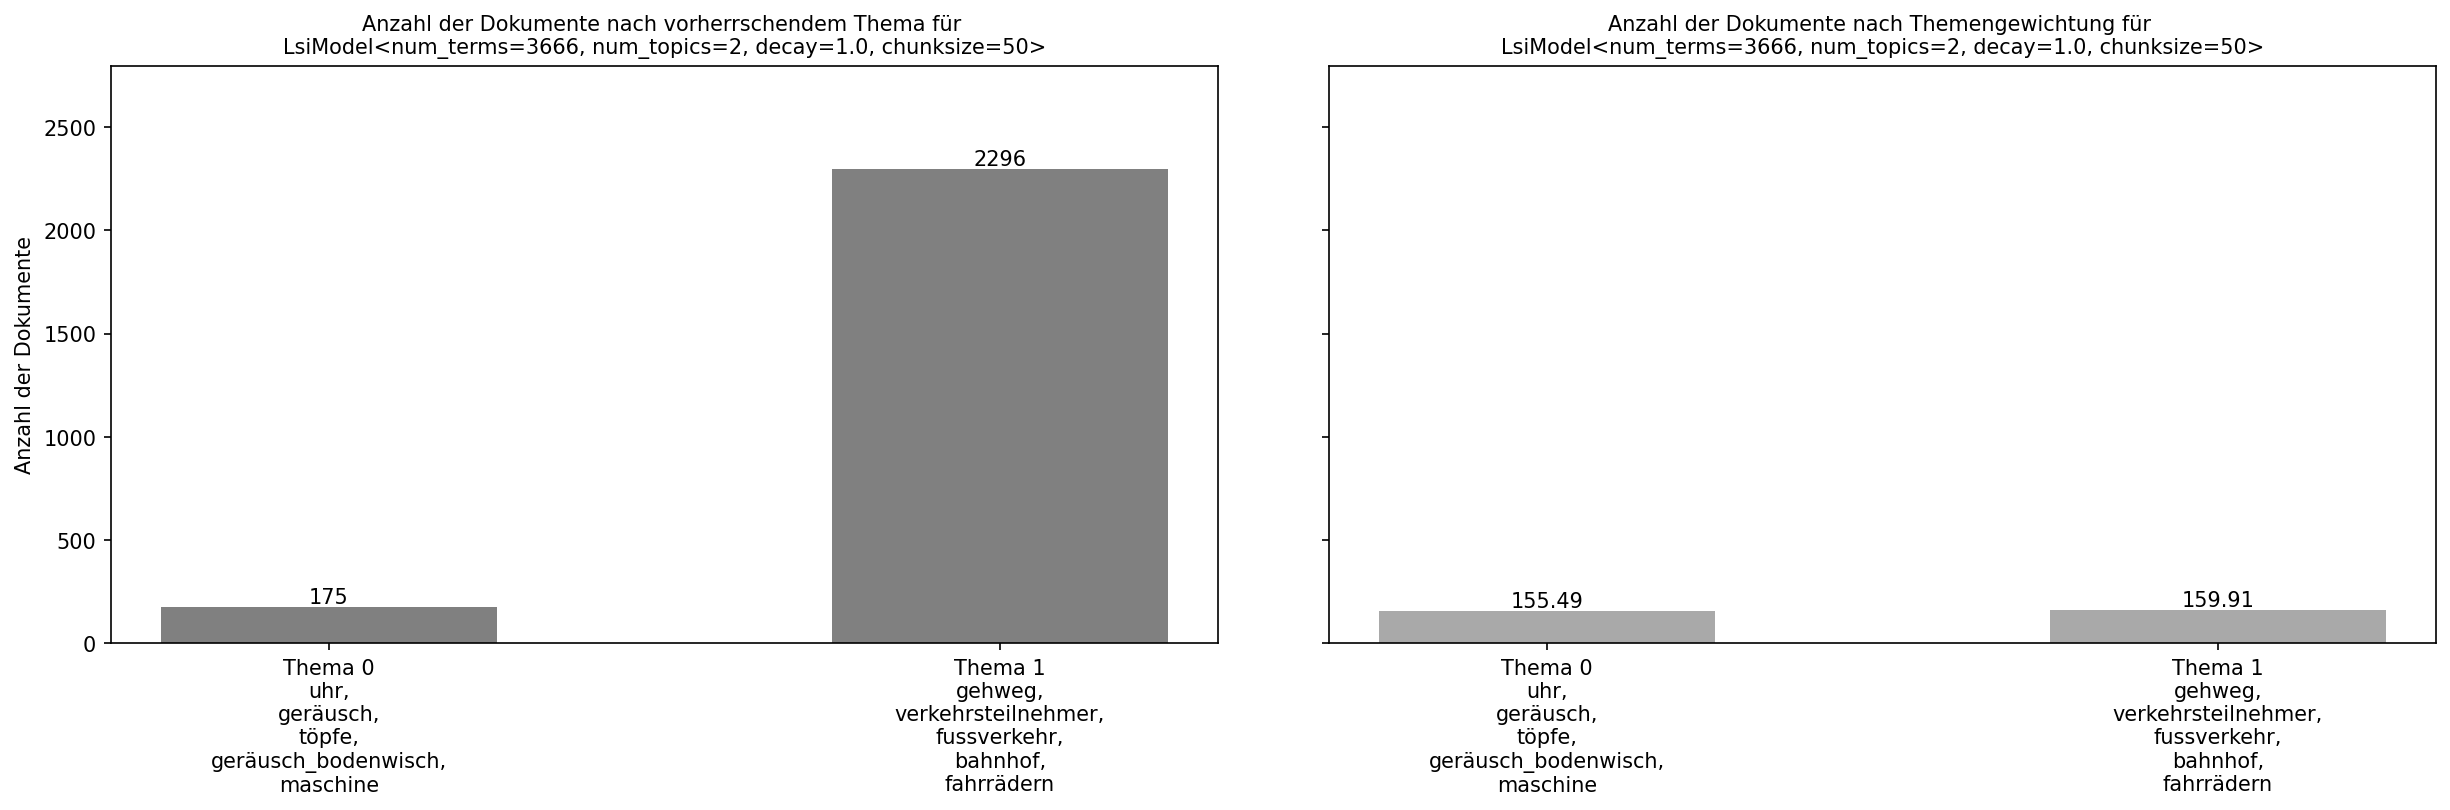

In [280]:
plot_topic_distribution(model=best_model_lsa_bow, corpus=bow_corpus, name='LSA_BoW')

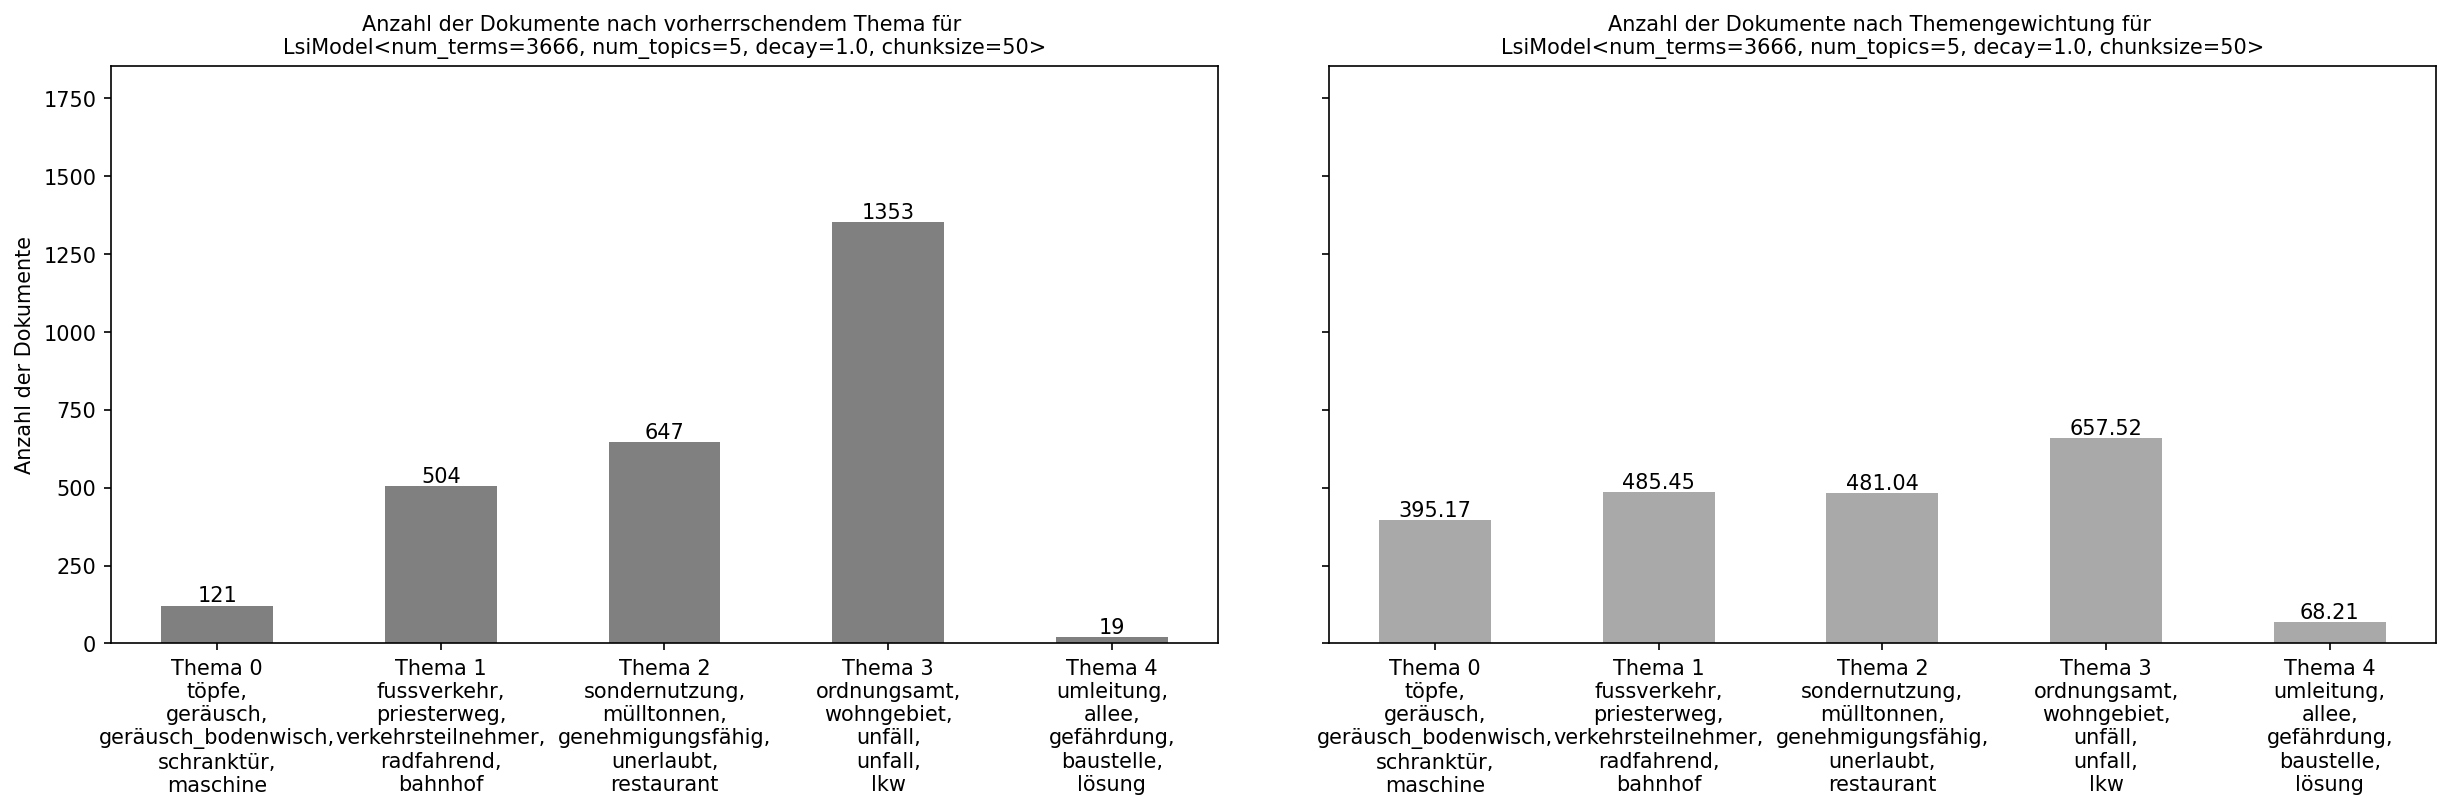

In [281]:
plot_topic_distribution(model=best_model_lsa_tfidf, corpus=corpus_lsa_tfidf, name='LSA_TFIDF')

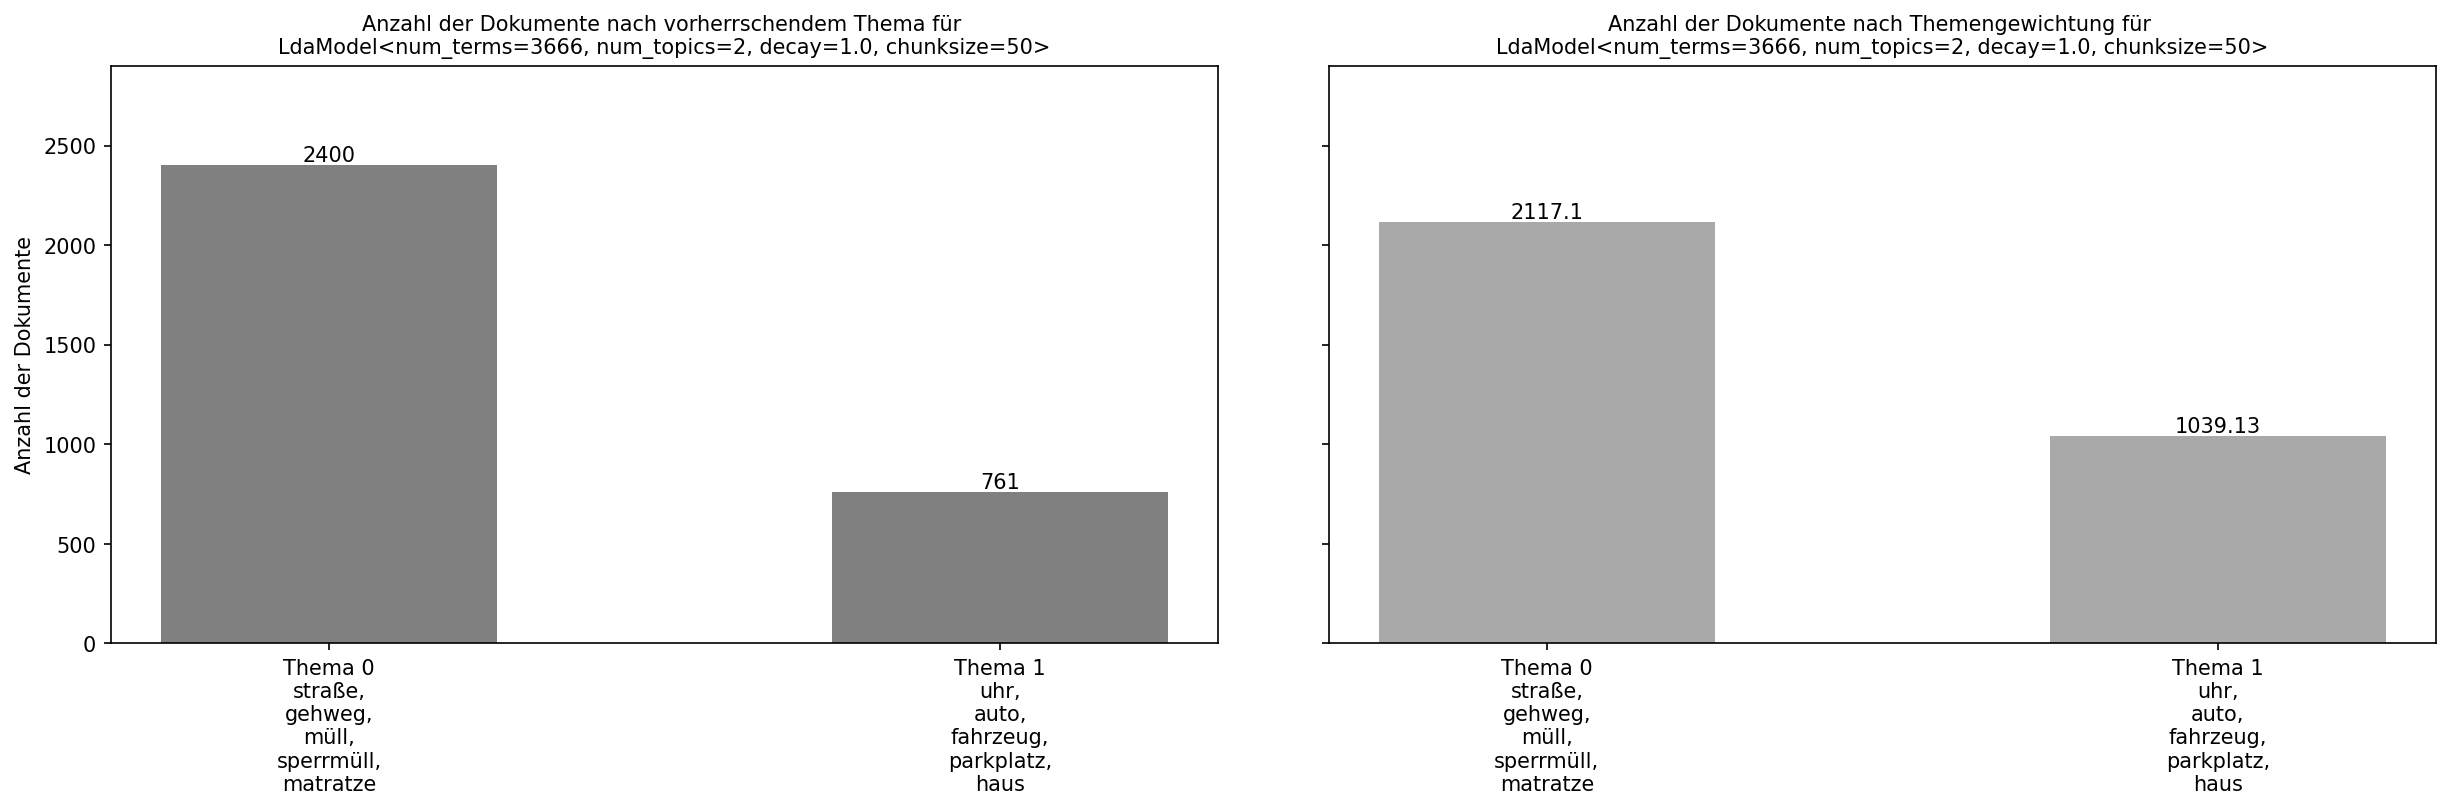

In [282]:
plot_topic_distribution(model=best_model_lda_bow, corpus=bow_corpus, name='LDA_BoW')

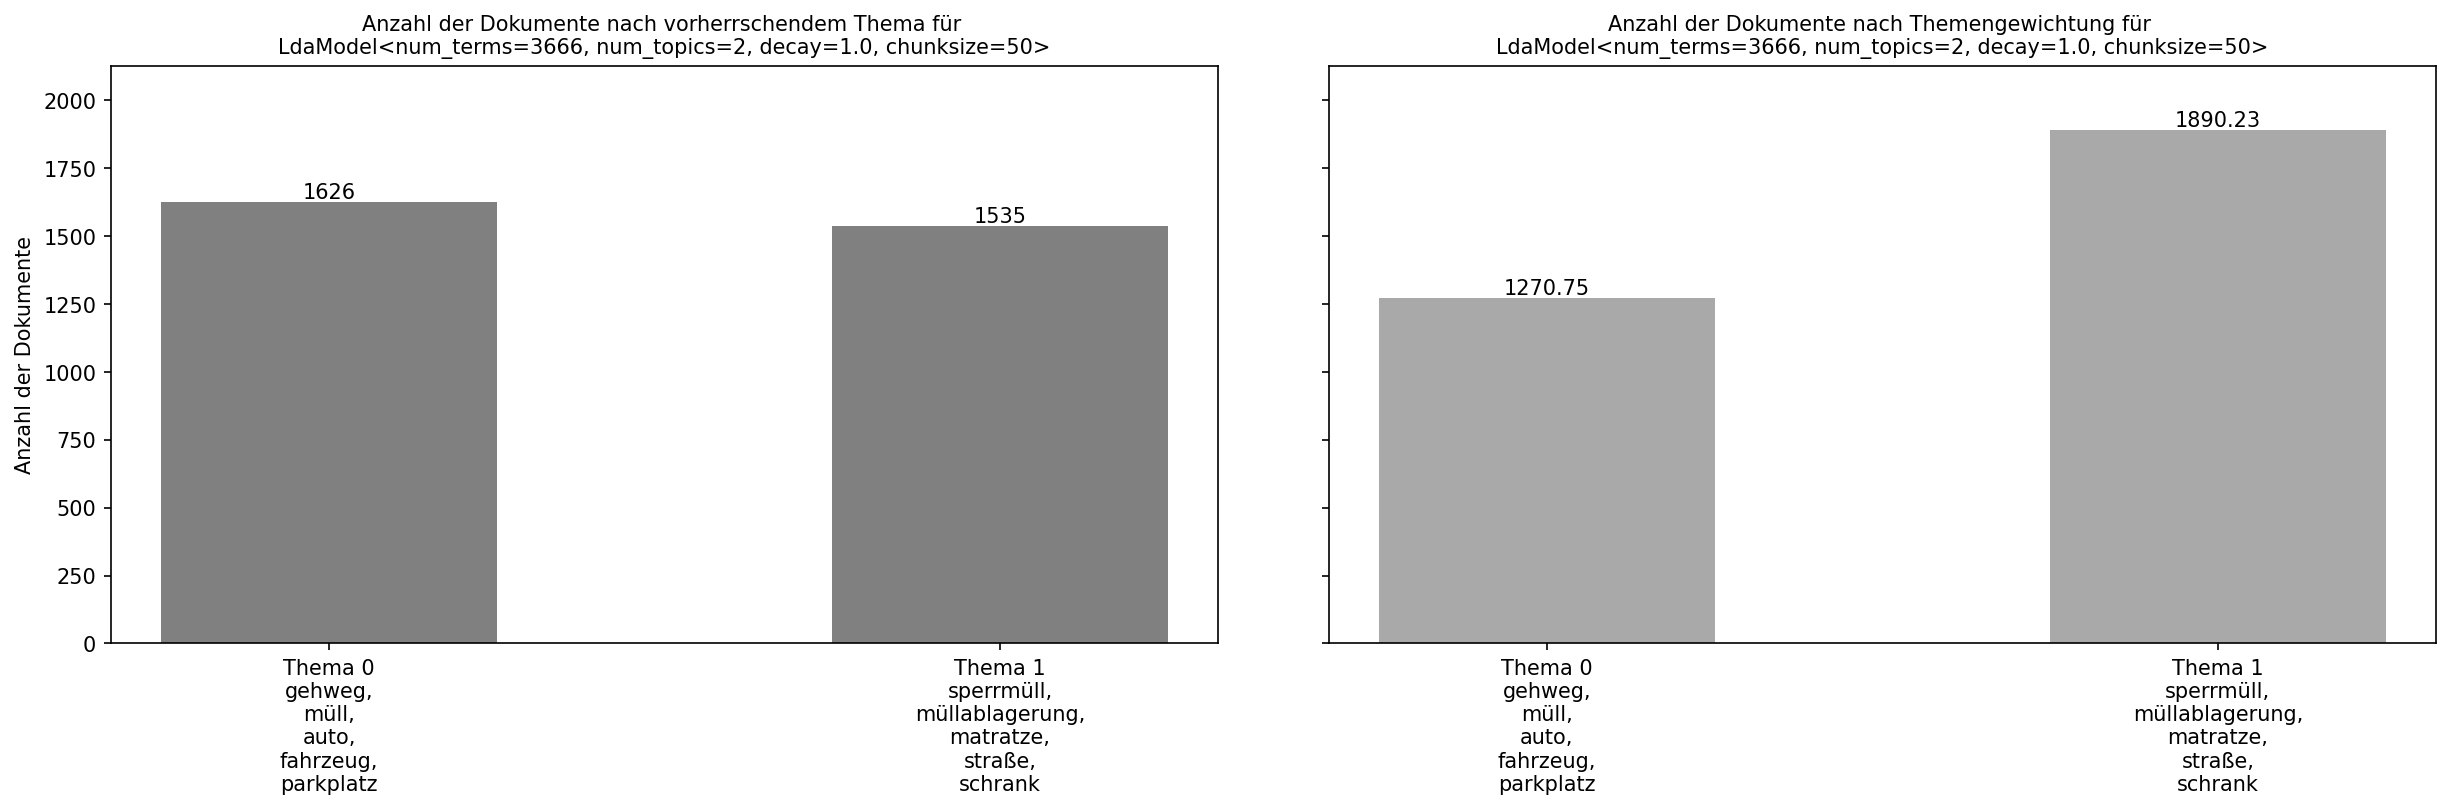

In [283]:
plot_topic_distribution(model=best_model_lda_tfidf, corpus=corpus_lda_tfidf, name='LDA_TFIDF')

In [69]:
# Visualisierung der Themen für LDA mit pyLDAvis, hier LDA BoW
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_model_lda_bow, bow_corpus, dictionary=best_model_lda_bow.id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
0      0.300696  0.0       1        1  58.07553
1     -0.300696  0.0       2        1  41.92447, topic_info=          Term        Freq       Total Category  logprob  loglift
2          uhr  209.000000  209.000000  Default  30.0000  30.0000
24      straße  325.000000  325.000000  Default  29.0000  29.0000
9         auto  153.000000  153.000000  Default  28.0000  28.0000
4     fahrzeug  147.000000  147.000000  Default  27.0000  27.0000
6       gehweg  197.000000  197.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
101  kontrolle   30.568863   30.678437   Topic2  -4.9281   0.8657
59      radweg   29.471596   29.581170   Topic2  -4.9647   0.8656
44     eingang   27.736089   27.845663   Topic2  -5.0254   0.8654
123  parkplätz   27.144991   27.254565   Topic2  -5.0469   0.8653
131    strasse   26.636217   26.745791   Topic2  -5.0658   0.8652

[91 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
20        1  1.002274               abfall
109       2  1.001787  absolut_halteverbot
88        2  0.998660             anhänger
43        2  1.005528             anwohner
9         2  0.998463                 auto
...     ...       ...                  ...
51        1  0.996182                tisch
54        2  1.007852                  tür
2         2  0.997348                  uhr
70        1  1.007049                unrat
94        1  1.003730           öffentlich

[62 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])